# Using the kmsr optimization on real data

In [1]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
from sklearn.metrics import DistanceMetric
import numpy as np

## Parsing a file

In [2]:
def read_data(filename):
    points = np.loadtxt(filename, delimiter=',', skiprows=1)  # uses spaces as delimiter by default, the first row is "x,y"
    return points

In [3]:
filename = "data_sets/ruspini.csv" # small dataset of four groups
points = read_data(filename)
k = 4

plt.title("Ruspini Dataset")
plt.scatter(points[:, 0], points[:, 1], marker='o', s=25, edgecolor="k", cmap="coolwarm")
plt.show()

FileNotFoundError: data_sets/ruspini.csv not found.

## Computing the LP

In [ ]:
# distance function
dist = DistanceMetric.get_metric('euclidean')

# we need all distances as possible radii
radii = dist.pairwise(points)

# model
m = gp.Model("kmsr")

# variables
R = m.addVars(len(radii), vtype=GRB.CONTINUOUS, lb=0, name="R")
L = m.addVars(len(radii), vtype=GRB.BINARY, name="L")
Y = m.addVars(len(radii), len(radii), vtype=GRB.BINARY, name="Y")

# objective function: minimize sum of r in R_i of i in L: y_{i,r}*r
m.setObjective(gp.quicksum(R[i] for i in range(len(radii))), GRB.MINIMIZE)

# constraints:
# every point covered
for j in range(len(radii)):
    m.addConstr(gp.quicksum(Y[i, j] for i in range(len(radii))) >= 1, f"coverage_{j}")

# covered point has to be within radius (easier to check in two steps than in the first constraint)
for i in range(len(radii)):
    for j in range(len(radii)):
        m.addConstr(radii[i][j] * Y[i, j] <= R[i], f"within_radius_{i}_{j}")

# if a point is covered by a center, that center must be open in this iteration
for i in range(len(radii)):
    for j in range(len(radii)):
        m.addConstr(Y[i, j] <= L[i], f"open_center_{i}_{j}")

# there can only be k centers open at a time
m.addConstr(gp.quicksum(L[i] for i in range(len(radii))) == k, "select_k_Centers")

# run gurobi optimizer
m.optimize()

final_centers = [points[i] for i in range(len(radii)) if L[i].x == 1]
final_radii = [R[i].x for i in range(len(radii)) if L[i].x == 1]

print("Optimal centers:")
for i in range(len(final_centers)): 
    print(f"Center at point {final_centers[i]} with radius {final_radii[i]}")

Set parameter Username
Set parameter LicenseID to value 2629995
Academic license - for non-commercial use only - expires 2026-03-01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 5800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 11326 rows, 5775 columns and 28125 nonzeros
Model fingerprint: 0xd682863c
Variable types: 75 continuous, 5700 integer (5700 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 150 rows and 75 columns
Presolve time: 0.05s
Presolved: 11176 rows, 5700 columns, 27900 nonzeros
Variable types: 75 continuous, 5625 integer (5625 binary)
Found heuristic solution: objective 114.4901743
Found heuristic solution: objective 113.7189518

Root relaxation: objective 4.123075e+01, 6

## Visual Solution

C:\Users\Mattis\AppData\Local\Temp\ipykernel_16808\788402991.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(points[:, 0], points[:, 1], marker='o', s=sizes, edgecolor="k", cmap="coolwarm")


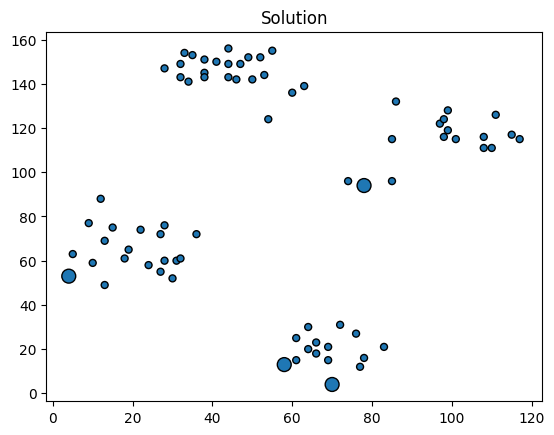

In [ ]:
# centers are enlarged
plt.title("Solution")
sizes = [100 if tuple(point) in map(tuple, final_centers) else 25 for point in points]
plt.scatter(points[:, 0], points[:, 1], marker='o', s=sizes, edgecolor="k", cmap="coolwarm")
plt.show()

Clearly, the objective function leads to very peculiar solutions, as it tends to prefer enlarging existing clusters. In this case, it leads to essentially on giant cluster.